In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score
#from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [3]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/Confmatrix.png')
    plt.show()
    
    return conf_matx

In [4]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.savefig('/home/jovyan/Acc_loss.png')
    plt.show()
   
    
    return fig

In [5]:
def loadImages():

    image_list = []
    

    for filename in tqdm.tqdm(sorted(glob.glob('/home/jovyan/DATA_MASTER_PROJECT/FINAL_Data/3_classes_t_96_HIGH/croppped_train/*.tiff'), key=natural_keys)): 
        im=cv2.imread(filename)
        imarray = np.array(im)
        imarray = imarray.astype('float32')
        image_list.append(imarray)

    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))
    
    path = '/home/jovyan/DATA_MASTER_PROJECT/FINAL_Data/3_classes_t_96_HIGH/train_labels.csv'     
    labels = pd.read_csv(path, usecols=["Type", "Category"],
                       sep="," )
    y_orig = np.array(labels['Category'])

    return x_orig, y_orig

In [6]:
def normalization(data, norm_mean):#, norm_sigma):
    
    x_scaled = np.subtract(data, norm_mean)# / norm_sigma
    data = x_scaled
    
    return data

In [7]:
def resize():
    rescaled = []

    for i in tqdm.tqdm(x_orig_1):

        scale_percent = 140 # percent of original size
        width = int(i.shape[1] / (scale_percent / 100))
        height = int(i.shape[0] / (scale_percent / 100))
        dim = (width, height)
        resized = cv2.resize(i, dim, interpolation = cv2.INTER_LANCZOS4)
        rescaled.append(resized)

    x_orig = np.reshape( rescaled, (len( rescaled), resized.shape[1], resized.shape[1], 3))

    return x_orig

In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)

In [9]:
pretrained_model = VGG16(weights='imagenet',include_top=False, input_shape=(64, 64, 3))

base_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('block3_pool').output)

In [10]:
x_orig_1, y_orig_1 = loadImages()
x_orig_1.shape, y_orig_1.shape

100%|██████████| 137571/137571 [02:01<00:00, 1133.01it/s]


((137571, 90, 90, 3), (137571,))

In [11]:
x_orig_1 = resize()
x_orig_1.shape

100%|██████████| 137571/137571 [00:28<00:00, 4878.68it/s]


(137571, 64, 64, 3)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_orig_1, y_orig_1, test_size=0.2, random_state=999 )
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((110056, 64, 64, 3), (27515, 64, 64, 3), (110056,), (27515,))

In [13]:
x_train_1, x_val, y_train_1, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=999 )
x_train_1.shape, x_val.shape, y_train_1.shape, y_val.shape

((88044, 64, 64, 3), (22012, 64, 64, 3), (88044,), (22012,))

In [14]:
unique, counts = np.unique(y_train_1, return_counts=True)
dict(zip(unique, counts))

{0: 18361, 1: 33050, 2: 36633}

In [15]:
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{0: 4564, 1: 8323, 2: 9125}

In [16]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train_1),y_train_1)
print('weights = ' + str(weights))

weights = [1.59838789 0.8879879  0.80113559]


In [17]:
y_train_1 = keras.utils.to_categorical(y_train_1)
y_test_1 = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)

y_train_1.shape, y_test_1.shape, y_val.shape

((88044, 3), (27515, 3), (22012, 3))

In [18]:
print('Shape:{0}\nMean:{1}\nSigma:{2}'.format(x_train_1.shape,np.mean(x_train_1),np.std(x_train_1)))

Shape:(88044, 64, 64, 3)
Mean:18.392343521118164
Sigma:26.812421798706055


In [19]:
norm_mean = np.mean(x_train_1)
norm_sigma = np.std(x_train_1)

x_train_1 = normalization(x_train_1, norm_mean)#, norm_sigma)

x_val = normalization(x_val, norm_mean)#, norm_sigma)

x_test = normalization(x_test, norm_mean)#, norm_sigma)


In [20]:
batch_size = 128

In [21]:
datagen = ImageDataGenerator()

datagen.fit(x_train_1)

train_gen = datagen.flow(x_train_1, y_train_1, batch_size=batch_size)

In [22]:
dat_val = ImageDataGenerator()

dat_val.fit(x_val)

val_gen = dat_val.flow(x_val, y_val, batch_size=batch_size)

In [26]:
m4 = Sequential()
m4.add(base_model)


m4.add(BatchNormalization())
m4.add(GlobalAveragePooling2D())
m4.add(Dense(64, activation='relu'))
m4.add(BatchNormalization())
m4.add(Activation ('relu'))
m4.add(Dense(3, activation = 'softmax'))

m4.summary()




Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 8, 8, 256)         1735488   
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
global_average_pooling2d_3 ( (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                

In [27]:
base_model.trainable = False

opt = keras.optimizers.Adam(lr=1e-3)

m4.compile(loss= keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])


In [28]:

epochs = 100

m4_h = m4.fit(train_gen,
                steps_per_epoch=(len(x_train_1)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = val_gen, 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 687.84375 steps, validate for 171.96875 steps
Epoch 1/100
688/687 [==============================] - 26s 39ms/step - loss: 0.9693 - accuracy: 0.5212 - val_loss: 0.9123 - val_accuracy: 0.5622
Epoch 2/100
688/687 [==============================] - 21s 30ms/step - loss: 0.8790 - accuracy: 0.5857 - val_loss: 0.8556 - val_accuracy: 0.5987
Epoch 3/100
688/687 [==============================] - 21s 31ms/step - loss: 0.8282 - accuracy: 0.6177 - val_loss: 0.8146 - val_accuracy: 0.6217
Epoch 4/100
688/687 [==============================] - 21s 30ms/step - loss: 0.7918 - accuracy: 0.6403 - val_loss: 0.7950 - val_accuracy: 0.6365
Epoch 5/100
688/687 [==============================] - 21s 31ms/step - loss: 0.7667 - accuracy: 0.6551 - val_loss: 0.7723 - val_accuracy: 0.6496
Epoch 6/100
688/687 [==============================] - 21s 30ms/step - loss: 0.7433 - accuracy: 0.6690 - val_loss: 0.7681 - val_accuracy: 0.6571
Epoch 7/100
688/687 [===

In [29]:
base_model.trainable = True

opt = keras.optimizers.Adam(lr=1e-5)

m4.compile(loss= keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])

In [30]:

epochs = 100

m4_h = m4.fit(train_gen,
                steps_per_epoch=(len(x_train_1)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = val_gen, 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 687.84375 steps, validate for 171.96875 steps
Epoch 1/100
688/687 [==============================] - 48s 70ms/step - loss: 0.5397 - accuracy: 0.7768 - val_loss: 0.6500 - val_accuracy: 0.7237
Epoch 2/100
688/687 [==============================] - 46s 67ms/step - loss: 0.5042 - accuracy: 0.7962 - val_loss: 0.6413 - val_accuracy: 0.7306
Epoch 3/100
688/687 [==============================] - 46s 67ms/step - loss: 0.4797 - accuracy: 0.8085 - val_loss: 0.6286 - val_accuracy: 0.7345
Epoch 4/100
688/687 [==============================] - 46s 67ms/step - loss: 0.4592 - accuracy: 0.8192 - val_loss: 0.5996 - val_accuracy: 0.7524
Epoch 5/100
688/687 [==============================] - 46s 67ms/step - loss: 0.4405 - accuracy: 0.8286 - val_loss: 0.5997 - val_accuracy: 0.7536
Epoch 6/100
688/687 [==============================] - 46s 67ms/step - loss: 0.4234 - accuracy: 0.8375 - val_loss: 0.6121 - val_accuracy: 0.7495
Epoch 7/100
688/687 [===

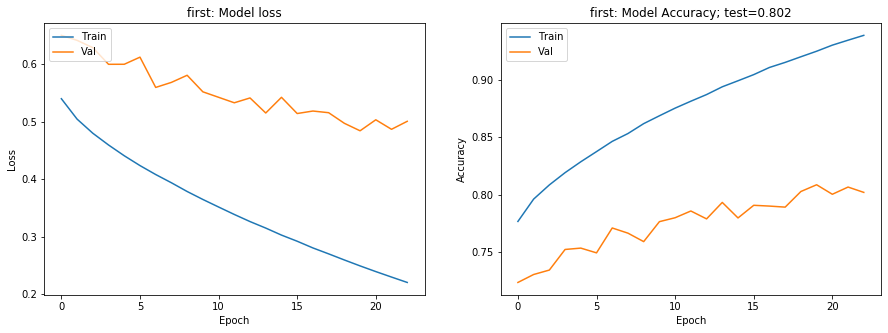

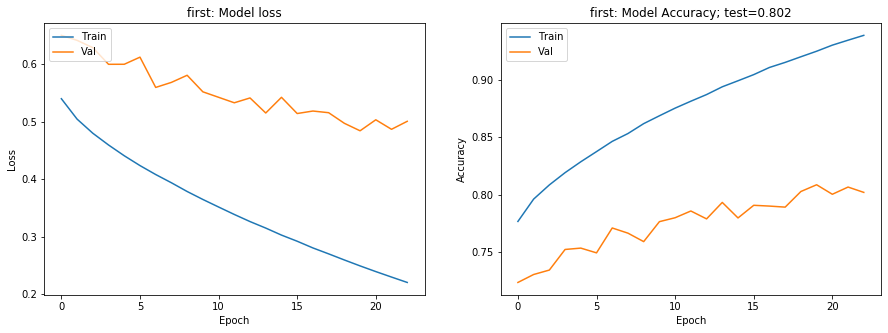

In [31]:
plot_history(m4_h, 'first')


In [32]:
scores = m4.evaluate(x_test, y_test_1)
print("\n%s: %.2f%%" % (m4.metrics_names[1], scores[1]*100))

27515/27515 [==============================] - 8s 285us/sample - loss: 0.5008 - accuracy: 0.8000

accuracy: 80.00%


In [33]:
test_preds = m4.predict(x_test)

In [34]:
preds_df = pd.DataFrame(test_preds)
predicted_labels = preds_df.idxmax(axis=1)

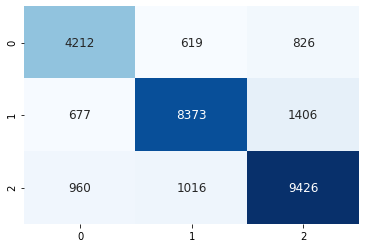

array([[4212,  619,  826],
       [ 677, 8373, 1406],
       [ 960, 1016, 9426]])

In [35]:
draw_confusion_matrix(y_test, predicted_labels)

In [36]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      5657
           1       0.84      0.80      0.82     10456
           2       0.81      0.83      0.82     11402

    accuracy                           0.80     27515
   macro avg       0.79      0.79      0.79     27515
weighted avg       0.80      0.80      0.80     27515



In [ ]:
p = '/home/jovyan/Saved_Models/'
m4.save(p + "CNN_NEW_DATA.h5")